In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
%matplotlib widget
%matplotlib inline
import numpy as np
from numpy.linalg import norm
import math
import pandas as pd
from tqdm import tqdm
from photutils.centroids import centroid_com, centroid_2dg, centroid_sources
from astroquery.vizier import Vizier
import astropy.units as u
import astropy.coordinates as coord
from PIL import Image
import os
from scipy.fft import rfft, rfftfreq
import scipy.stats as stats
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from AstroTUBIN_functions import *

defining target coordinates and import of star coordinates

In [2]:
tgt_coord = np.array([83.5, -5])
norm_star_coord, catalog = load_star_catalog(tgt=tgt_coord, vmag_lim=5.65, radius=8)

Import of TUBIN images

In [4]:
#bw_images, times = load_png_images('/Users/lukas/Dokumente/Uni/Thesis/orion_campaign/')
bw_images, times = load_png_images('/Users/lukas/Desktop/Code/Test/')

TUBIN_VIS_20230223_155602_944_1.png
TUBIN_VIS_20230223_155630_944_1.png
TUBIN_VIS_20230223_155654_944_1.png
TUBIN_VIS_20230223_155720_944_1.png
TUBIN_VIS_20230223_155744_944_1.png
import complete


apply bad pixel map on raw images

In [5]:
mask_weights = load_badpixelmap(bw_images)

bad pixel map file loaded


In [6]:
#applying bad pixel mask
corr_images = np.array([correct_hotpxl(i, mask_weights) for i in bw_images])

100%|██████████| 2748/2748 [00:00<00:00, 3045.97it/s]


correction complete


Detecting Centroid Positions in Images

In [7]:
#find centroid position of stars
images_xy = np.array([find_centroid_coord(i) for i in corr_images], dtype=object)

100%|██████████| 105/105 [00:07<00:00, 13.18it/s]

centroid detection complete


Extracting Astrophotometric Parameter

In [8]:
#generating target pixel files for each star
images_tpfs = np.array([generate_tpf(i, j) for i, j in zip(corr_images, images_xy)], dtype=object)
print('target pixel files created')

#generate radial curves of stars
rad_lightcurves = get_rad_lightcurves(images_tpfs, images_xy)
print('star curves created')

#set aperture radius and sum star flux
aperture, flux, mean_curve, bkg_noise = measure_star(rad_lightcurves)
print('analysis complete')

target pixel files created


100%|██████████| 5/5 [00:00<00:00,  8.19it/s]


star curves created
analysis complete


connect parameter to star coordinates and reduce data set acourding to limit parameter

In [9]:
#merge data 
images_data = np.array([images_xy, flux, aperture, mean_curve, rad_lightcurves, images_tpfs[None]], dtype=object)

#reduce dataset according to log(flux) and aperture radius
red_data = reduce_data(images_data, mag_limit = 10.75, rad_limit = 2.75) #[x,y-coord, log_flux, aperture radius, mean value over radius curve, pixel value over radius, target pixel file]

print('dataset reduction complete')
print('reduction ratio: {:.2f}'.format(red_data[0][0].shape[0]/images_data[0][0].shape[0]))

dataset reduction complete
reduction ratio: 0.45


Application of camera model on image data and referencing stars

In [10]:
#transform detector position in angular position
coord_ang = camera_angle(np.transpose(red_data)[0])

#find matching stars, connect data and calculate camera pointing
pointing, flux_time, ap_time, conn_stars, rad_star_curves = match_images(coord_ang, red_data, tgt_coord, norm_star_coord[:,0:2], mode=1)  #mode 0: relative (default ref_idx=0); mode 1: absolute (star catalog)

creating time series...
analyse reference image...


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

...time series created


saving pointing coordinates of each frame

In [11]:
np.savetxt('pointing_ra_dec', np.round(pointing, 6), delimiter=',', fmt='%s') #RA, DEC, Angle to N, residual radec
print(pointing[:,0:3])

[[  84.28155594   -5.36555084 -165.68482437]
 [  84.28167866   -5.3679823  -165.67729522]
 [  84.27764577   -5.35870797 -165.66569052]
 [  84.28579016   -5.29715979 -165.62536203]
 [  84.25538318   -5.34832675 -165.63148497]]


Visualisation of pointing coordinates

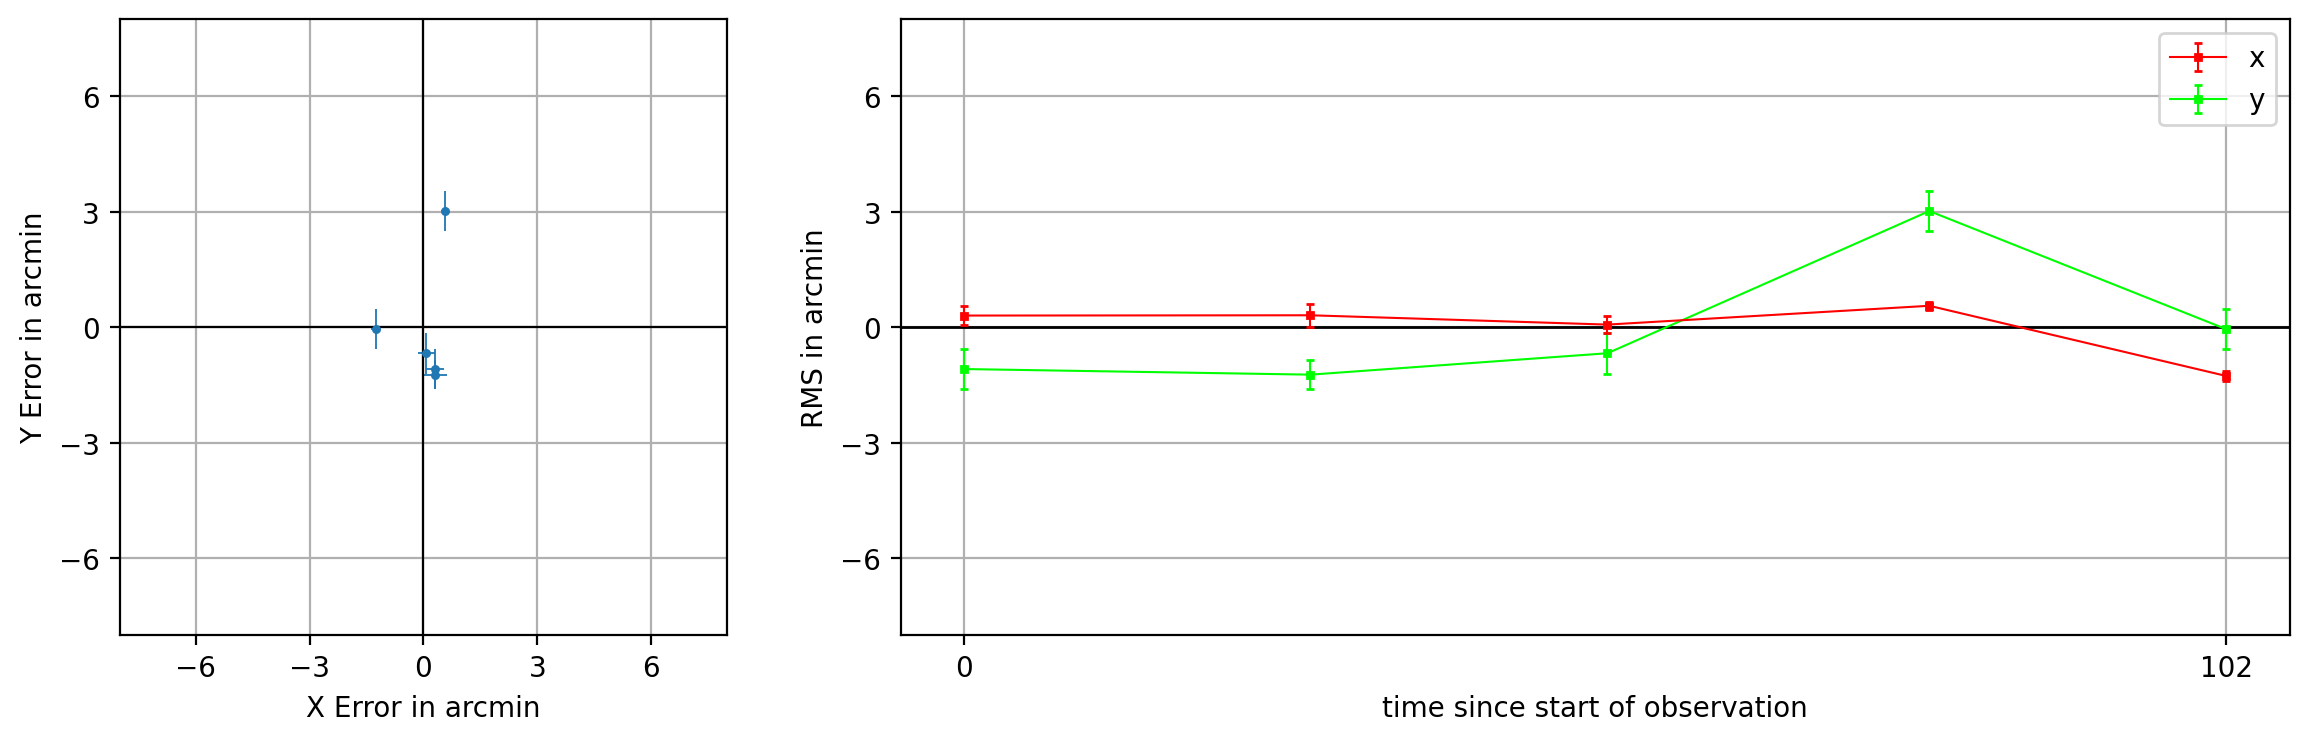

In [12]:
plot_pointing(pointing, times)

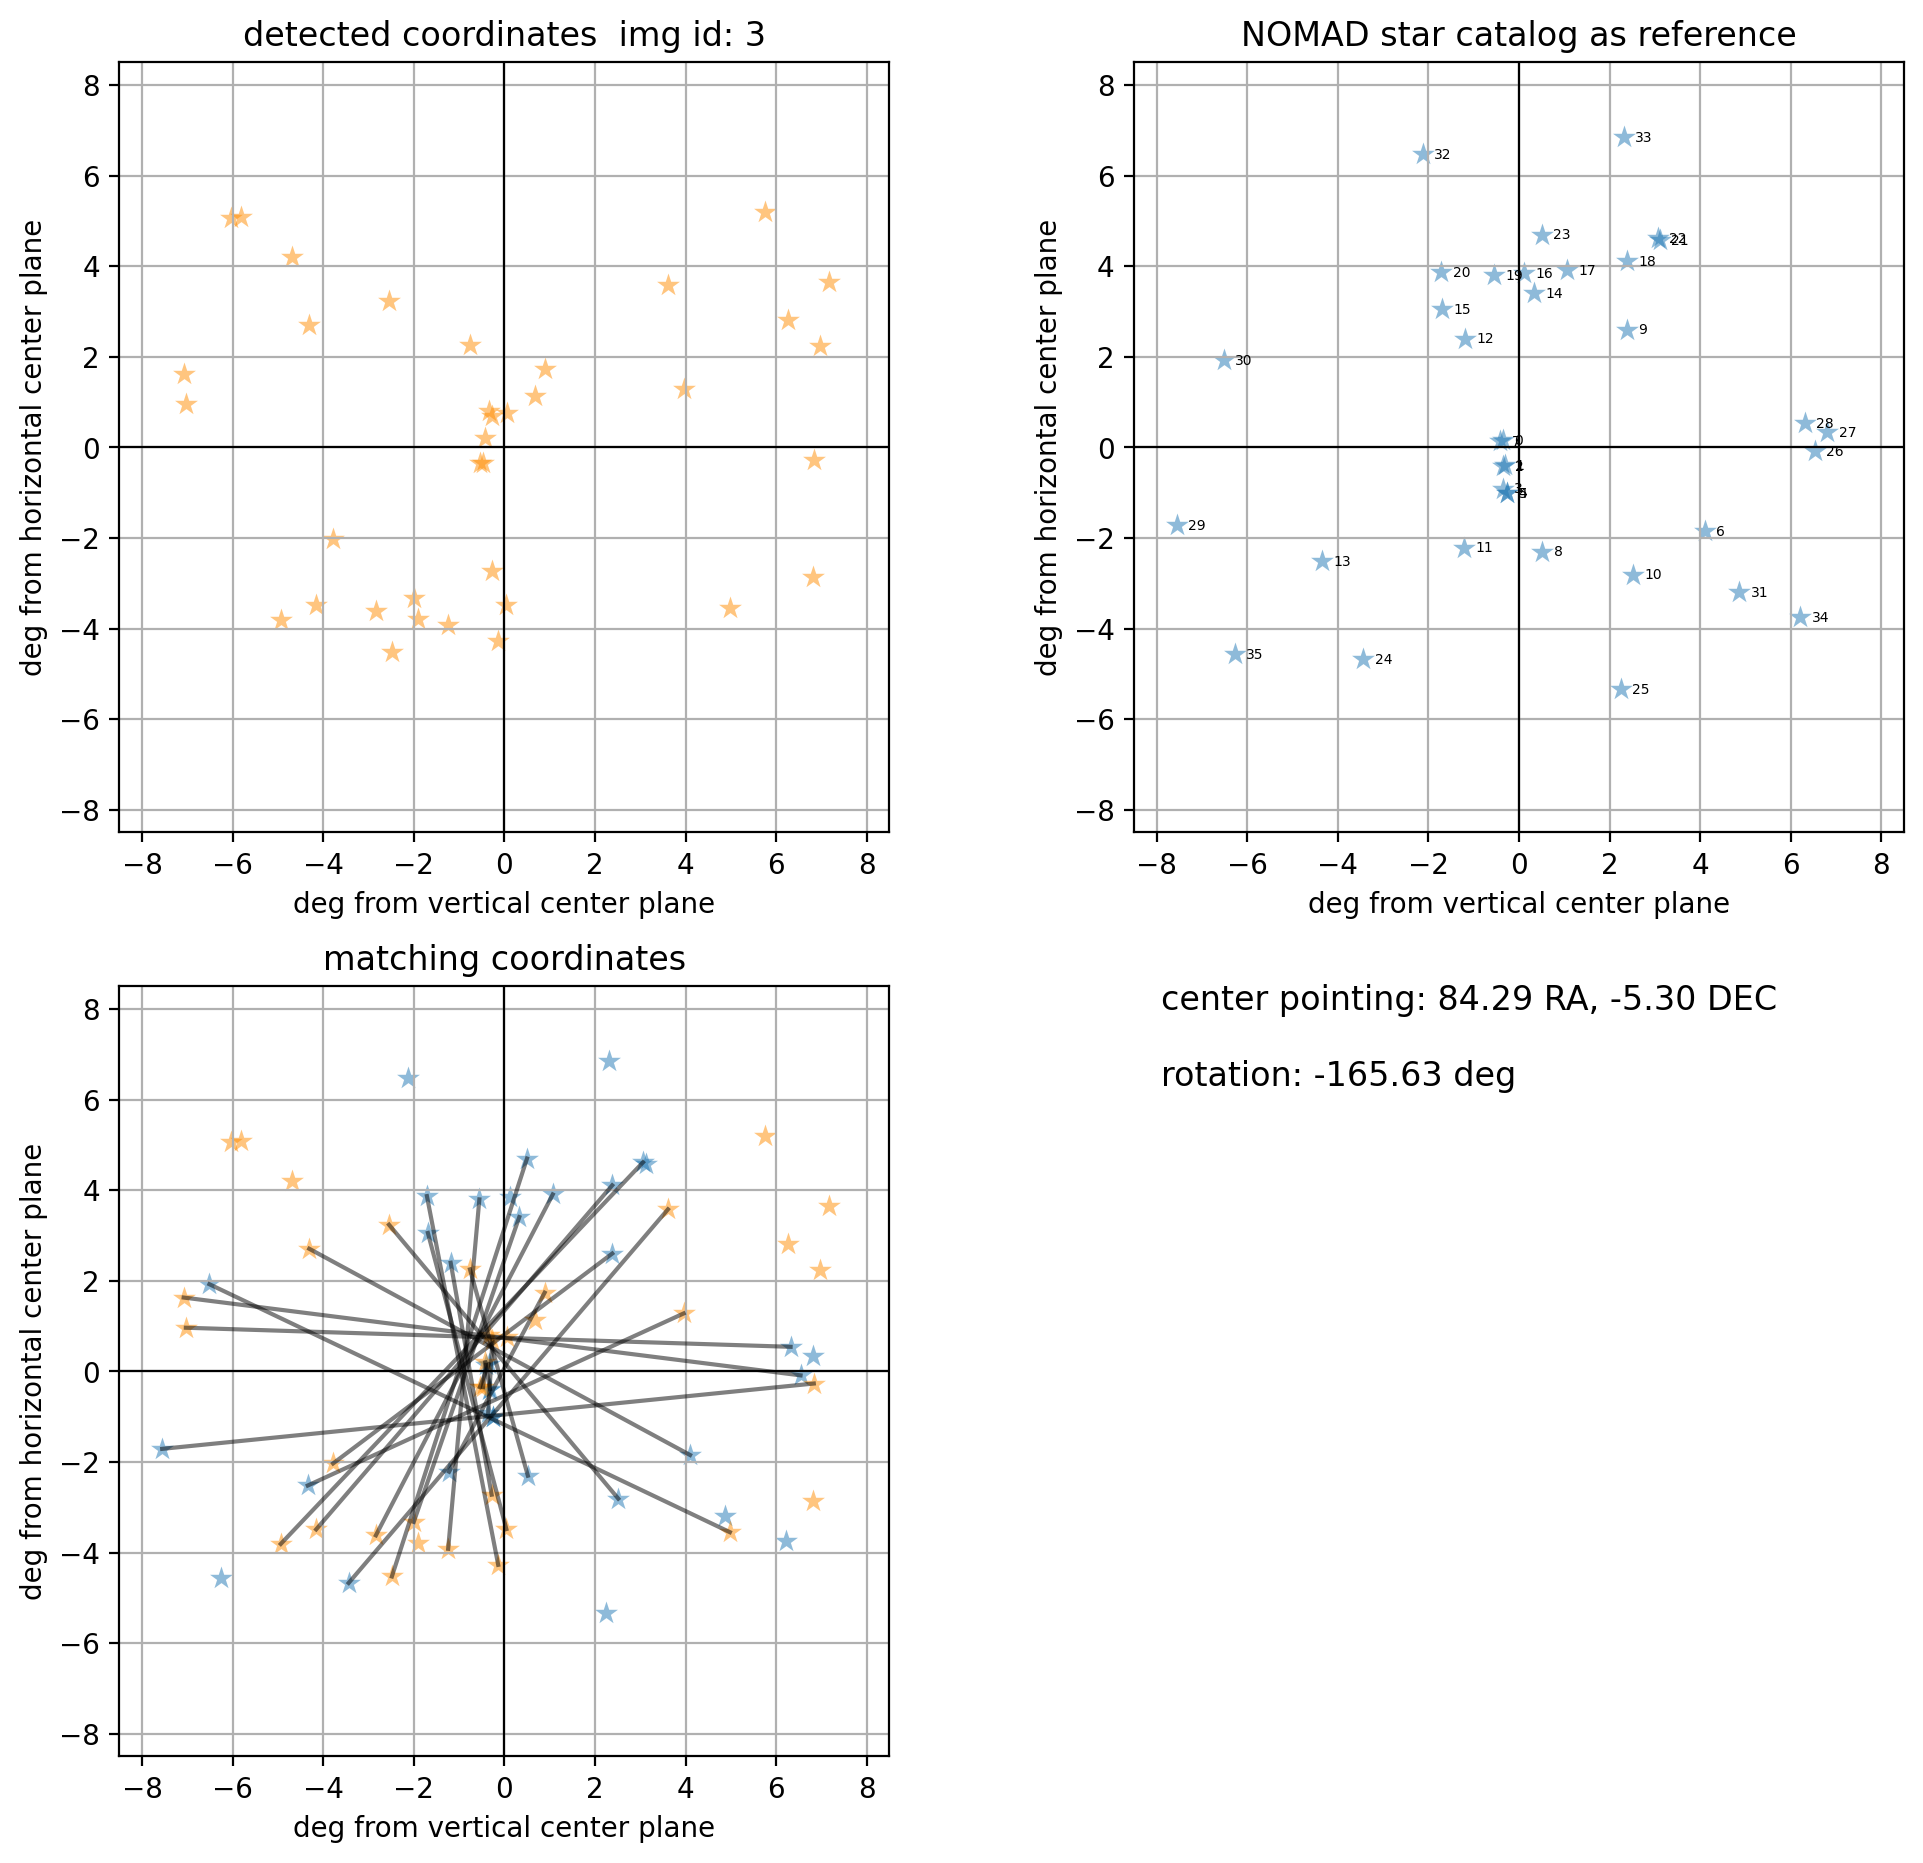

In [13]:
plot_registration(3, coord_ang, norm_star_coord[:,0:2], conn_stars, pointing) 

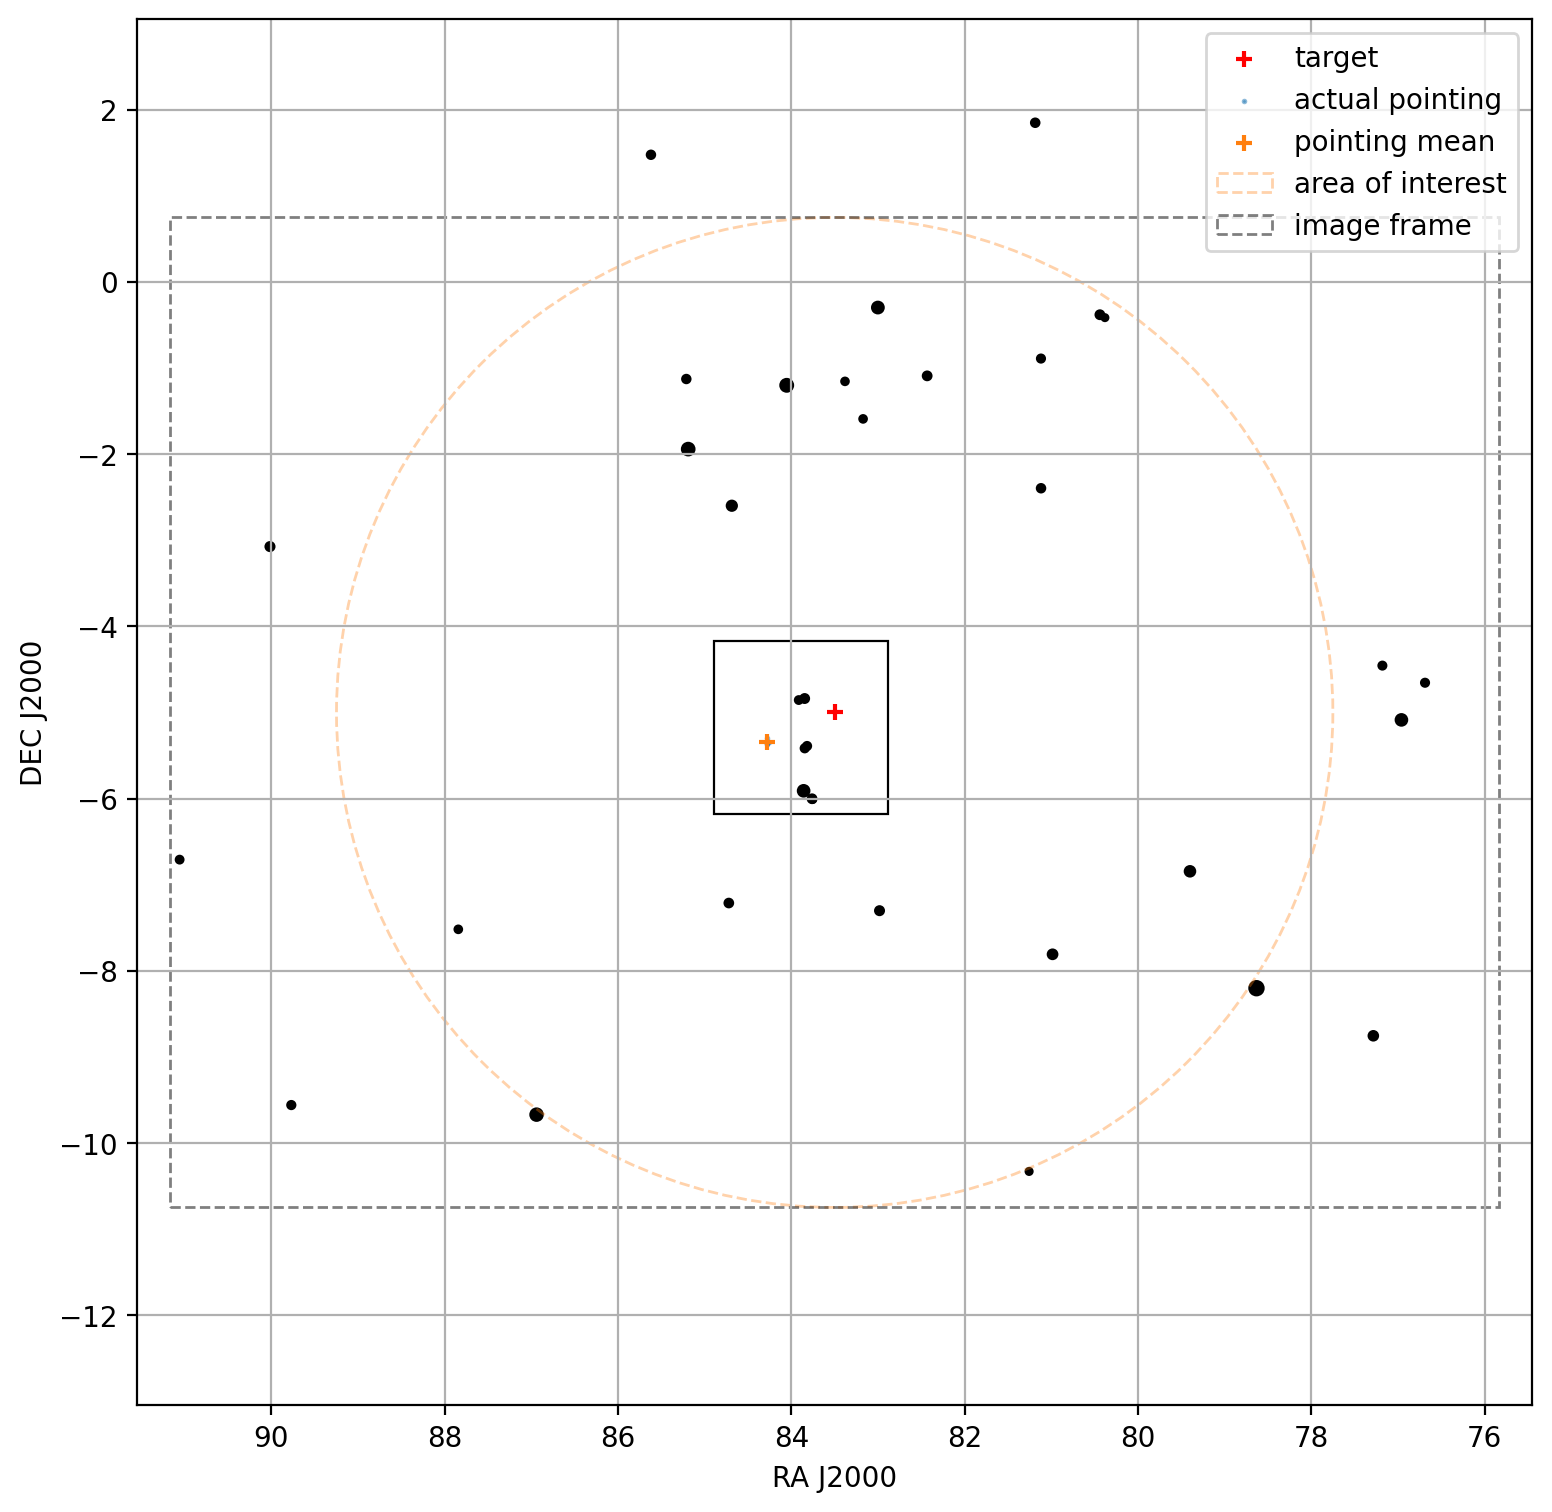

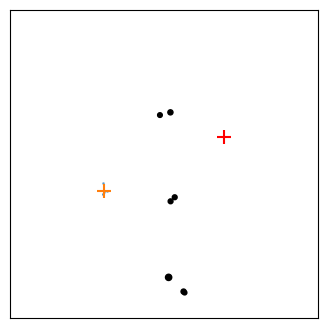

In [14]:
plot_pointing_in_stars(tgt_coord, pointing, catalog, norm_star_coord[:,2])

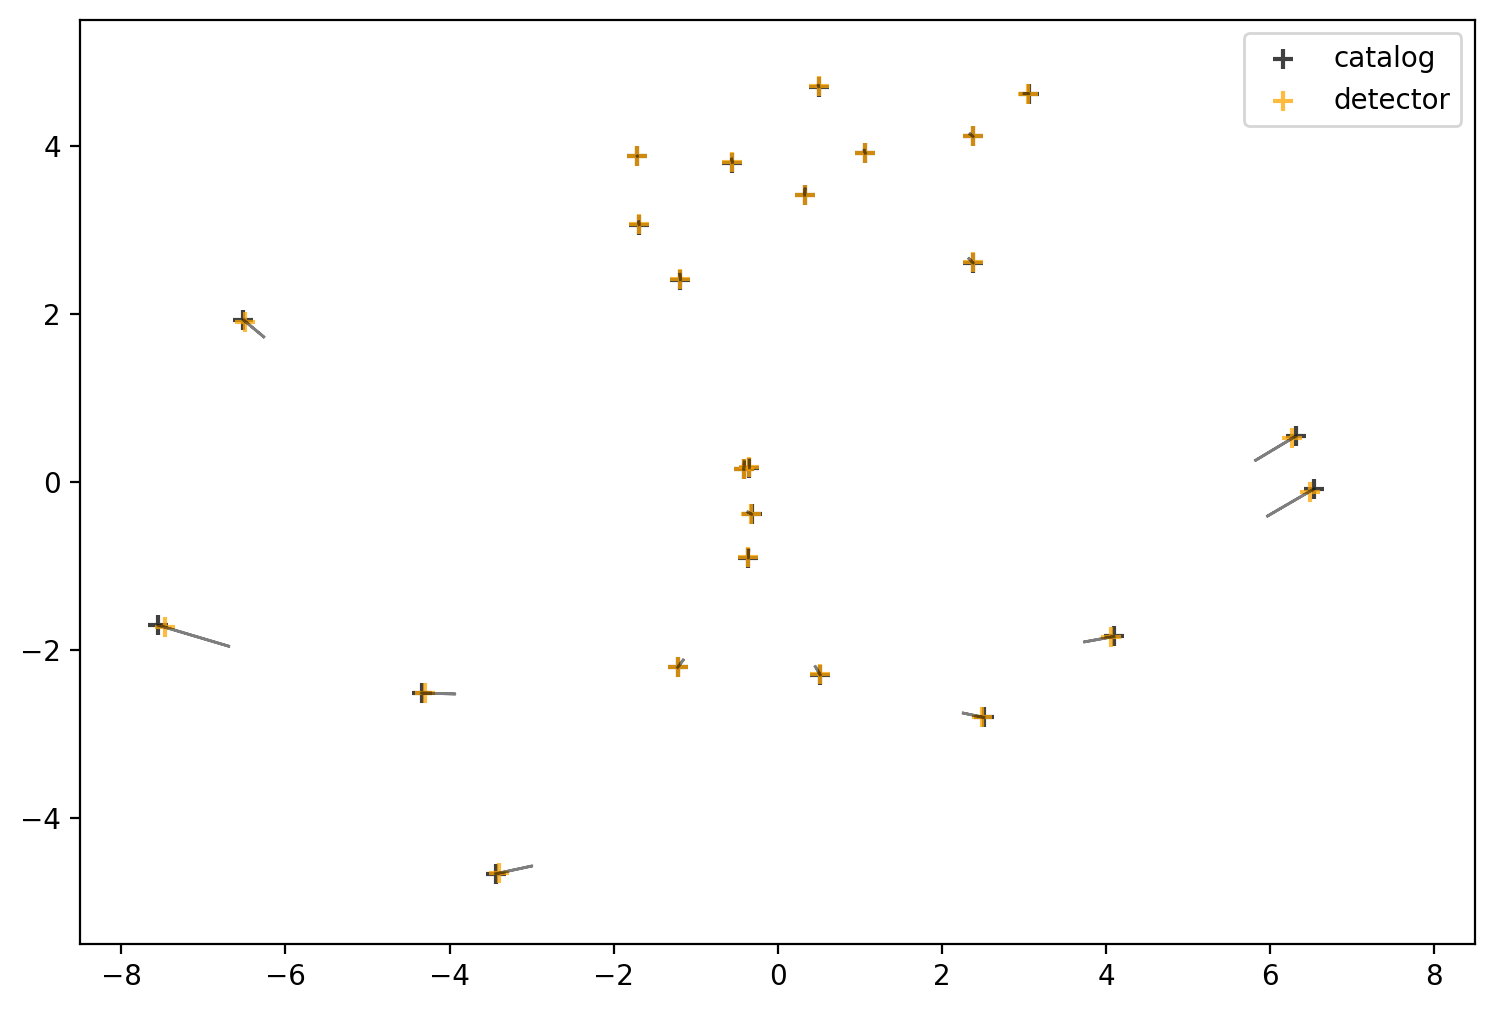

In [26]:
plot_overlay_det_starcat(3, tgt_coord, pointing, conn_stars)